# 🏙️ Warsaw Apartment Rent Analysis

**Goal:** understand what drives rental prices in Warsaw using a small DS pipeline.

## What’s inside this project
- **Data cleaning & validation** (`src/utils.py`)
- **One-command pipeline** to produce charts and processed data (`scripts/run_pipeline.py`)
- **Notebook report** (this file) with explanations + visuals

## Dataset schema (minimum)
- `price_pln` — monthly rent price in PLN
- `district` — district / neighborhood name
- `area_m2` — apartment area (m²)
- `rooms` — number of rooms


## 0) Setup
This notebook expects a CSV file at:
- `data/raw/rents.csv`

If you already ran the pipeline, you should also have:
- `data/processed/rents_processed.csv`
- charts in `figures/`


In [1]:
import sys
from pathlib import Path

# Find the folder that contains "src/"
here = Path.cwd()
candidates = [here, *here.parents]

project_root = None
for p in candidates:
    if (p / "src").exists():
        project_root = p
        break

if project_root is None:
    raise FileNotFoundError("Can't find 'src' folder above current directory.")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root detected:", project_root)
print("src exists:", (project_root / "src").exists())


Project root detected: C:\Users\Kostiantyn\Desktop\bbbbb-main
src exists: True


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from src.config import RAW_PATH, PROCESSED_PATH
from src.utils import check_columns, basic_clean, quick_report

print('RAW_PATH:', RAW_PATH)
print('PROCESSED_PATH:', PROCESSED_PATH)
print('RAW exists:', os.path.exists(str(RAW_PATH)))
print('PROCESSED exists:', os.path.exists(str(PROCESSED_PATH)))

RAW_PATH: C:\Users\Kostiantyn\Desktop\bbbbb-main\data\raw\rents.csv
PROCESSED_PATH: C:\Users\Kostiantyn\Desktop\bbbbb-main\data\processed\rents_processed.csv
RAW exists: True
PROCESSED exists: True


## 1) Load raw data

In [3]:
df_raw = pd.read_csv(RAW_PATH)
df_raw.head()

,price_pln,district,area_m2,rooms
0,3500,Śródmieście,45,2
1,2800,Mokotów,38,2
2,2200,Bielany,30,1
3,4200,Wola,60,3


## 2) Validate + clean
We:
- check required columns
- normalize types
- remove missing values
- add `price_per_m2`
- filter extreme outliers (safe defaults)


In [4]:
check_columns(df_raw)
df = basic_clean(df_raw)
print('After clean:', quick_report(df))
df.head()

After clean: rows: 4 | districts: 4 | price_pln: min=2200, median=3150, max=4200 | area_m2: min=30, median=42, max=60


,price_pln,area_m2,rooms,district,price_per_m2
0,3500,45,2,Śródmieście,77.777778
1,2800,38,2,Mokotów,73.684211
2,2200,30,1,Bielany,73.333333
3,4200,60,3,Wola,70.000000


## 3) Quick EDA
### 3.1 Price distribution
Shows typical price segments and spread.

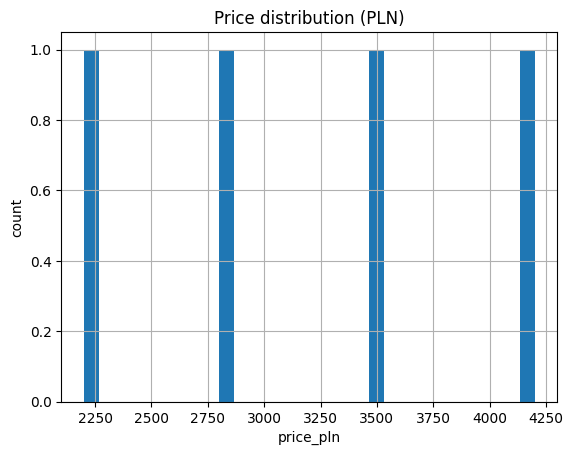

In [5]:
plt.figure()
df['price_pln'].hist(bins=30)
plt.title('Price distribution (PLN)')
plt.xlabel('price_pln')
plt.ylabel('count')
plt.show()

### 3.2 Area vs price
Checks if larger apartments tend to be more expensive.

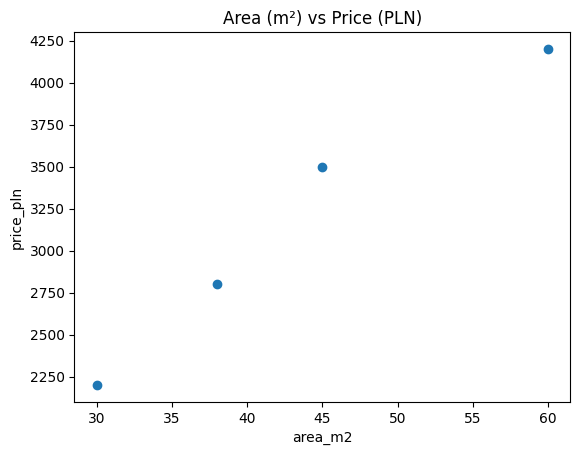

In [6]:
plt.figure()
plt.scatter(df['area_m2'], df['price_pln'])
plt.title('Area (m²) vs Price (PLN)')
plt.xlabel('area_m2')
plt.ylabel('price_pln')
plt.show()

### 3.3 Average price by district
Highlights which districts are more expensive on average (Top 15).

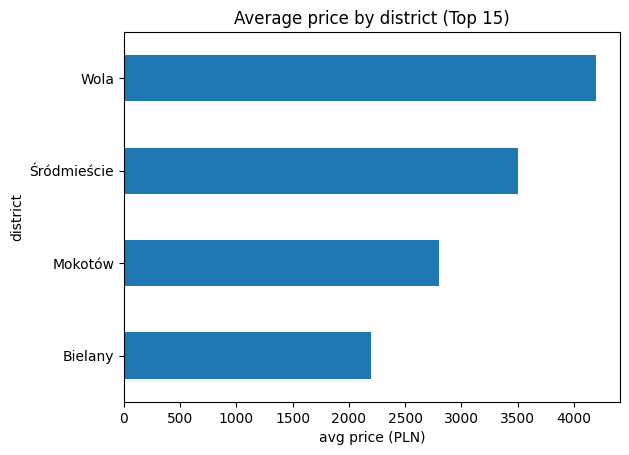

district
Bielany        2200.0
Mokotów        2800.0
Śródmieście    3500.0
Wola           4200.0
Name: price_pln, dtype: float64

In [7]:
top = (
    df.groupby('district')['price_pln']
      .mean()
      .sort_values(ascending=False)
      .head(15)
      .sort_values()
)

plt.figure()
top.plot(kind='barh')
plt.title('Average price by district (Top 15)')
plt.xlabel('avg price (PLN)')
plt.ylabel('district')
plt.show()

top

### 3.4 Price per m²
A strong normalized metric to compare districts fairly.

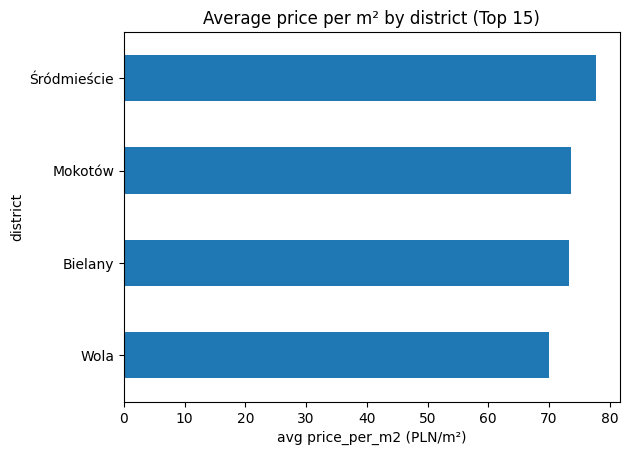

district
Wola           70.000000
Bielany        73.333333
Mokotów        73.684211
Śródmieście    77.777778
Name: price_per_m2, dtype: float64

In [8]:
top_m2 = (
    df.groupby('district')['price_per_m2']
      .mean()
      .sort_values(ascending=False)
      .head(15)
      .sort_values()
)

plt.figure()
top_m2.plot(kind='barh')
plt.title('Average price per m² by district (Top 15)')
plt.xlabel('avg price_per_m2 (PLN/m²)')
plt.ylabel('district')
plt.show()

top_m2

## 4) Save processed dataset
Saves a clean version to `data/processed/` for future modeling.

In [9]:
os.makedirs(os.path.dirname(str(PROCESSED_PATH)), exist_ok=True)
df.to_csv(PROCESSED_PATH, index=False)
print('Saved:', PROCESSED_PATH)

Saved: C:\Users\Kostiantyn\Desktop\bbbbb-main\data\processed\rents_processed.csv


## 5) Conclusions
- **Area** is strongly associated with price (bigger apartments → higher rent).
- **District** is a major driver of price differences across Warsaw.
- **Price per m²** is useful to compare districts more fairly.

Next steps (optional):
- add more features (floor, furnished, distance to center)
- build a simple regression model to predict price
